# Bike Safety Final Models

## Introduction

The goal of this project is to create a Predictive Model that is able to predict how severe a bike accident was.

For this, we have two target columns we plan to use in different ways:
- BikeInjury, which classifies how severe the injury of a biker was; from No Injury to Killed.
- AmbulanceR, which tells us whether an ambulance was called or not to the scene.

In the following sections, we'll tackle different ways of using these columns as our target column.

In this first section, we'll set up the code required for all approaches.

In [14]:
# Visualization and data manipulation libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Preprocessing and metrics libraries
from sklearn.model_selection import train_test_split, learning_curve, GridSearchCV, StratifiedKFold
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, make_scorer, ConfusionMatrixDisplay

# Machine learning models libraries
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

In [15]:
# Read out our database of bike accidents
BikeCrashData = pd.read_csv('../data/NCDOT_BikePedCrash.csv')

# Keeping only the relevant columns
BikeCrashData = BikeCrashData[['AmbulanceR',
        'BikeAgeGrp','BikeDir', 'BikeInjury', 'BikePos','BikeRace', 'BikeSex', 
        'CrashDay', 'CrashHour', 'CrashMonth',
        'NumLanes','RdConditio', 'RdConfig','RdFeature', 'RdSurface', 'RuralUrban', 'SpeedLimit', 'Weather', 'Workzone']]


# Recombining speed limit into three categories
# 1. Low (0-25 mph)
# 2. Medium (26-45 mph)
# 3. High (46+ mph)
def speed_limit(x):
    if x in ['5 - 15 MPH', '20 - 25  MPH', 'Unknown']:
        return 0
    
    elif x in ['30 - 35  MPH', '40 - 45  MPH']:
        return 1
    
    else:
        return 2
    
BikeCrashData['SpeedLimit']=BikeCrashData['SpeedLimit'].apply(speed_limit)

# Combine months into seasons
def month_season(x):
    if x in ['December','January', 'February']:
        return 0
    
    elif x in ['March','April', 'May']:
        return 1
    
    elif x in ['June','July', 'August']:
        return 2
    
    else:
        return 3

BikeCrashData['CrashMonth']=BikeCrashData['CrashMonth'].apply(month_season)

# Combine hours into day parts
def day_part(hour):
    if hour < 6:
        return 0
    
    elif hour < 12:
        return 1
    
    elif hour < 18:
        return 2
    
    else:
        return 3
    
BikeCrashData['CrashHour']=BikeCrashData['CrashHour'].apply(day_part)

# Combinging age groups in three categories
def age_group(x):
    if x in ['0-5', '6-10', '11-15', '16-19']:
        return 0
    
    elif x in ['20-24', '25-29', '30-39' ]:
        return 1
    
    else:
        return 2

BikeCrashData['BikeAgeGrp']=BikeCrashData['BikeAgeGrp'].apply(age_group)

# Adding a binary column for the two main targets
BikeCrashData['AmbulanceR']=BikeCrashData['AmbulanceR'].apply(lambda x: 1 if x == 'No' else 0) ##### NOTE THE CHANGE in notation here

# Dropping unknown injuries
BikeCrashData.drop(BikeCrashData[BikeCrashData['BikeInjury'] == 'Unknown Injury'].index, inplace=True)

# Recombining injuries into two main classes (Light '1' and Severe '0')
BikeCrashData['BikeInjury']=BikeCrashData['BikeInjury'].replace({'B: Suspected Minor Injury':0,'C: Possible Injury':0, 'O: No Injury':0,'K: Killed':1,'A: Suspected Serious Injury':1 })
# Again, NOTE keeping the minority class as 1 and the majority class as 0. This is important for the model to work properly.

# For other features, we just use get dummies to convert them into binary features
BikeCrashData = pd.get_dummies(BikeCrashData, columns=['BikeDir','CrashDay', 'BikePos','BikeRace', 'BikeSex','NumLanes','RdConditio', 'RdConfig','RdFeature', 'RdSurface', 'RuralUrban', 'Weather', 'Workzone'])*1

C:\Users\ayman\AppData\Local\Temp\ipykernel_39164\1252022509.py:79: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  BikeCrashData['BikeInjury']=BikeCrashData['BikeInjury'].replace({'B: Suspected Minor Injury':0,'C: Possible Injury':0, 'O: No Injury':0,'K: Killed':1,'A: Suspected Serious Injury':1 })


In [16]:
# Using the same KFold for GridSearchCV and model_metrics, for consistency and visualization purposes below.
def skf(n_splits = 5, shuffle = True, random_state = 582):
    return StratifiedKFold(n_splits=n_splits, shuffle=shuffle, random_state=random_state)


def model_metrics(model, X_train, y_train, n_splits = 5, pos_label = 1):
    """
    model_metrics function is used to evaluate the model performance using k-fold cross-validation.
    It calculates various metrics such as accuracy, precision, recall, f1-score, and roc_auc_score and returns the mean of these metrics.
    The function also visualizes the confusion matrix for each fold.

    :param model: the machine learning model to be evaluated
    :param X_train: the training data features
    :param y_train: the training data target variable
    :param n_splits: the number of splits for k-fold cross-validation
    :return: returns a dictionary containing the mean of the evaluation metrics
    """ 

    accuracy_scores = []
    precision_scores = []
    recall_scores = []
    f1_scores = []
    roc_auc_scores = []
    class_label = ' (class ' + str(pos_label) + ')' 

    kfold = skf(n_splits)
    
    fig, axis = plt.subplots(1, n_splits, figsize=(20, 5))
    
    for index, (train_index, test_index) in enumerate(kfold.split(X_train, y_train)):
        # training sets
        X_tt = X_train.iloc[train_index]
        y_tt = y_train.iloc[train_index]
        # holdout sets
        X_ho = X_train.iloc[test_index]
        y_ho = y_train.iloc[test_index]

        # train and evaluate model
        model.fit(X_tt, y_tt)
        pred = model.predict(X_ho)

        # collect the evaluation metric of each fold
        accuracy_scores.append(accuracy_score(y_ho, pred))
        precision_scores.append(precision_score(y_ho, pred, pos_label = pos_label))
        recall_scores.append(recall_score(y_ho, pred, pos_label = pos_label))
        f1_scores.append(f1_score(y_ho, pred, pos_label = pos_label))
        roc_auc_scores.append(roc_auc_score(y_ho, pred))
        ConfusionMatrixDisplay.from_predictions(y_ho, pred, ax=axis[index])
        axis[index].set_title("Split " + str(index+1))

    plt.show()
    return {'accuracy' : np.mean(accuracy_scores),
            'precision' + class_label : np.mean(precision_scores),
            'recall' + class_label : np.mean(recall_scores),
            'f1-score' + class_label : np.mean(f1_scores),
            'roc_auc_score'  : np.mean(roc_auc_scores)}

In [17]:
# Extending the LogisticRegression class to include a threshold parameter
class LogisticRegressionThreshold(LogisticRegression):
    def __init__(self, threshold=0.5, penalty='l2', dual=False, tol=1e-4, C=1.0, fit_intercept=True, intercept_scaling=1, class_weight=None, random_state=None, solver='lbfgs', max_iter=100, multi_class='auto', verbose=0, warm_start=False, n_jobs=None, l1_ratio=None):
        super().__init__(penalty=penalty, dual=dual, tol=tol, C=C, fit_intercept=fit_intercept, intercept_scaling=intercept_scaling, class_weight=class_weight, random_state=random_state, solver=solver, max_iter=max_iter, verbose=verbose, warm_start=warm_start, n_jobs=n_jobs, l1_ratio=l1_ratio)
        self.threshold = threshold

    def predict(self, X):
        y_prob = self.predict_proba(X)
        return (y_prob[:, 1] >= self.threshold).astype(int)

    def predict_proba(self, X):
        return super().predict_proba(X)

In [18]:
# Extending the RandomForestClassifier class to include a threshold parameter
class RandomForestClassifierThreshold(RandomForestClassifier):
    def __init__(self, threshold=0.5, n_estimators=100, criterion='gini', max_depth=None, min_samples_split=2, min_samples_leaf=1, min_weight_fraction_leaf=0.0, max_features='sqrt', max_leaf_nodes=None, min_impurity_decrease=0.0, bootstrap=True, oob_score=False, n_jobs=None, random_state=None, verbose=0, warm_start=False, class_weight=None, ccp_alpha=0.0, max_samples=None, monotonic_cst=None):
        super().__init__(n_estimators=n_estimators, criterion=criterion, max_depth=max_depth, min_samples_split=min_samples_split, min_samples_leaf=min_samples_leaf, min_weight_fraction_leaf=min_weight_fraction_leaf, max_features=max_features, max_leaf_nodes=max_leaf_nodes, min_impurity_decrease=min_impurity_decrease, bootstrap=bootstrap, oob_score=oob_score, n_jobs=n_jobs, random_state=random_state, verbose=verbose, warm_start=warm_start, class_weight=class_weight, ccp_alpha=ccp_alpha, max_samples=max_samples, monotonic_cst=monotonic_cst)
        self.threshold = threshold

    def predict(self, X):
        y_prob = self.predict_proba(X)
        return (y_prob[:, 1] >= self.threshold).astype(int)

    def predict_proba(self, X):
        return super().predict_proba(X)

## Target: Ambulance Response

### Cross Validation

We'll first test our models using the AmbulanceR column as our target.

Notice in the code below, we don't touch the Bike_test.

We only do the cross-validation on the training data set.

#### Set-up

In [19]:
# Start out with our base model
models_ambulance_r = {
    'base_model (log_reg_unweighted)': LogisticRegression(penalty=None, max_iter=1000)
}

In [20]:
# Splitting the data into training and test sets, stratifying on Ambulance Response
Bike_train, Bike_test = train_test_split(BikeCrashData.copy(),
                                        shuffle=True, 
                                        test_size=0.2, 
                                        random_state=614,
                                        stratify=BikeCrashData['AmbulanceR'])

features = Bike_train.drop(columns=['AmbulanceR','BikeInjury']).columns
X_train = Bike_train[features]
y_train = Bike_train['AmbulanceR']

In [21]:
# Create a list of class weights to test out in different models
weights_ambulance_r = list(range(20, 40))
weights_ambulance_r = [{0: weight, 1: 100 - weight} for weight in weights_ambulance_r]

In [22]:
# Using GridSearchCV to find the best hyperparameters for the Logistic Regression model
amb_reg_grid_cv = GridSearchCV(LogisticRegression(), 
                          param_grid = {'penalty': [None],
                                        'max_iter': [1000],
                                        'class_weight': weights_ambulance_r}, 
                          scoring = 'roc_auc', 
                          cv = skf(n_splits=5))

amb_reg_grid_cv.fit(X_train, y_train)

# Add our best estimator to the models to cross-validate
models_ambulance_r['logistic_regression (roc_auc_opt)'] = amb_reg_grid_cv.best_estimator_

In [23]:
# Using GridSearchCV to find the best hyperparameters for the Random Forest model
amb_for_grid_cv = GridSearchCV(RandomForestClassifier(), 
                          param_grid = {'n_estimators': [250, 500, 1000],
                                        'max_depth': [12, 14, 16],
                                        'class_weight': ['balanced']},
                          scoring = make_scorer(recall_score, pos_label=0),
                          cv = skf(n_splits=5))

amb_for_grid_cv.fit(X_train, y_train)

# Add our best estimator to the models to cross-validate
models_ambulance_r['random_forest (neg_recall_opt)'] = amb_for_grid_cv.best_estimator_

In [24]:
# Print out models
models_ambulance_r

{'base_model (log_reg_unweighted)': LogisticRegression(max_iter=1000, penalty=None),
 'logistic_regression (roc_auc_opt)': LogisticRegression(class_weight={0: 38, 1: 62}, max_iter=1000, penalty=None),
 'random_forest (neg_recall_opt)': RandomForestClassifier(class_weight='balanced', max_depth=16, n_estimators=500)}

In [208]:
# Print out models
models_ambulance_r

{'base_model (log_reg_unweighted)': LogisticRegression(max_iter=1000, penalty=None),
 'logistic_regression (roc_auc_opt)': LogisticRegression(class_weight={0: 32, 1: 68}, max_iter=1000, penalty=None),
 'random_forest (neg_recall_opt)': RandomForestClassifier(class_weight='balanced', max_depth=16, n_estimators=500)}

#### Results

MODEL: base_model (log_reg_unweighted)
CONFUSION MATRICES:


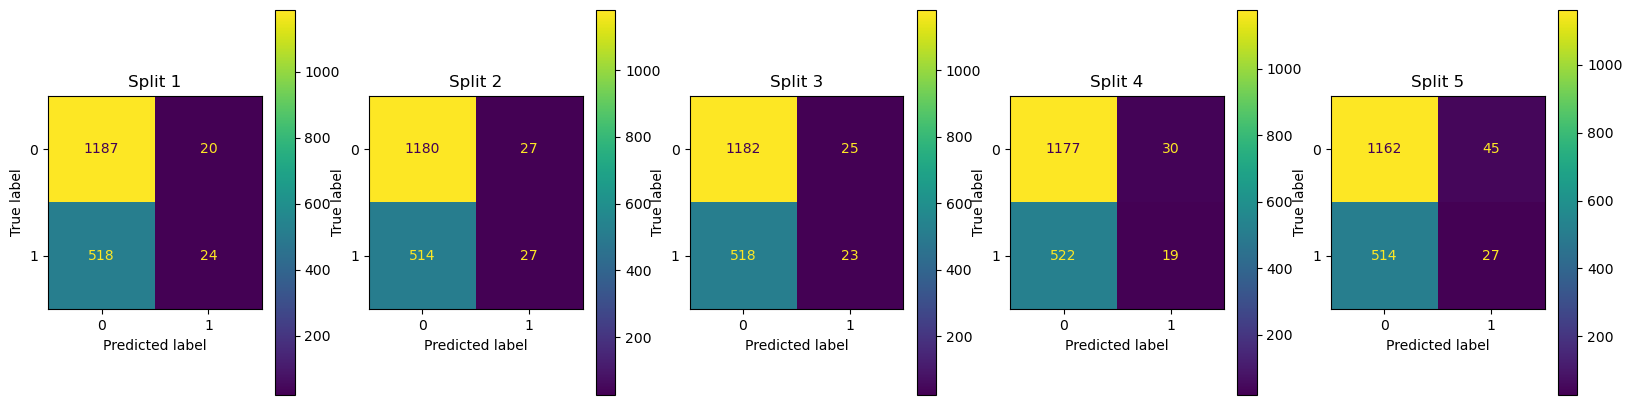

AVERAGE METRICS:
accuracy : 0.6873349661722357
precision (class 0) : 0.6948271643618886
recall (class 0) : 0.975642087821044
f1-score (class 0) : 0.8116244514242537
roc_auc_score : 0.5099940050116671
-----------------------------------


MODEL: logistic_regression (roc_auc_opt)
CONFUSION MATRICES:


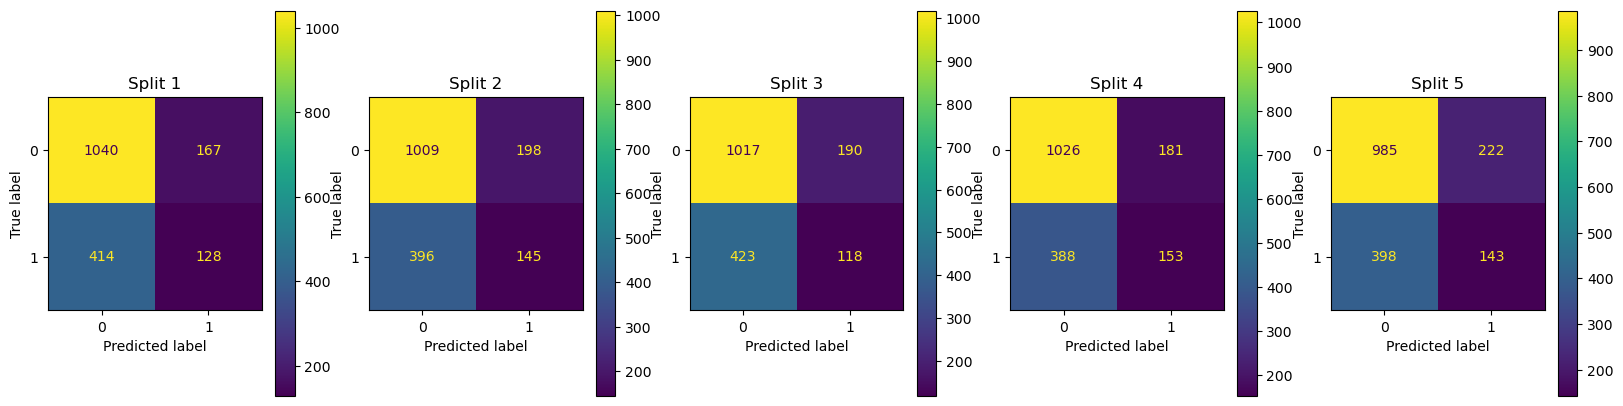

AVERAGE METRICS:
accuracy : 0.6594201590186219
precision (class 0) : 0.7154977270642766
recall (class 0) : 0.8412593206296602
f1-score (class 0) : 0.7732382417331924
roc_auc_score : 0.5475730683810734
-----------------------------------


MODEL: random_forest (neg_recall_opt)
CONFUSION MATRICES:


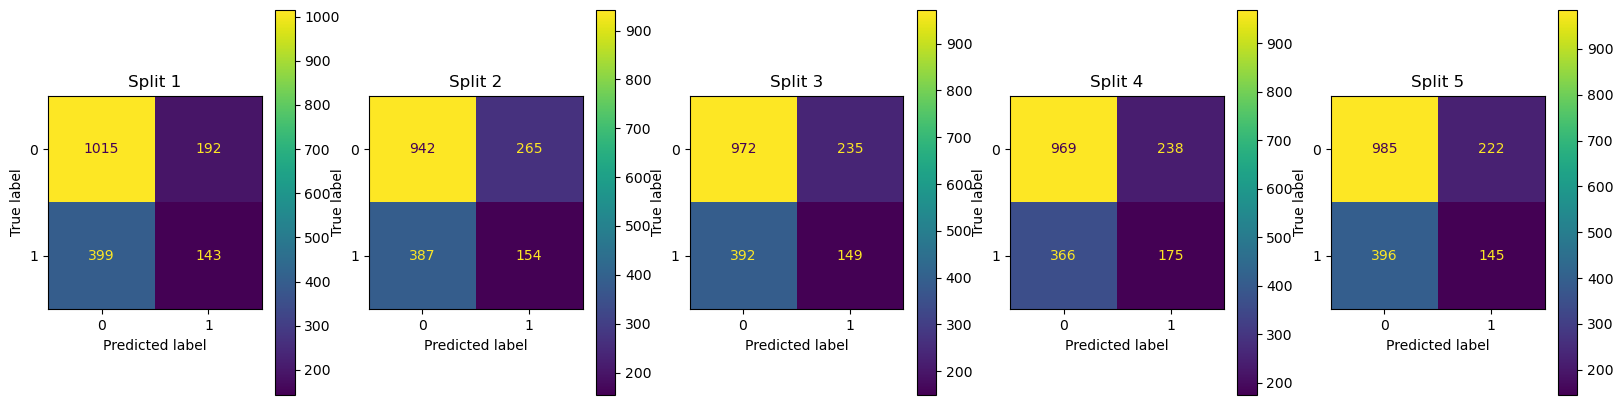

AVERAGE METRICS:
accuracy : 0.6462629184640324
precision (class 0) : 0.71566586568355
recall (class 0) : 0.8091135045567522
f1-score (class 0) : 0.7594278310525666
roc_auc_score : 0.5460976325670311
-----------------------------------




In [25]:
# Showing the confusion matrices and metrics for each model
for (key, model) in models_ambulance_r.items():
    print('MODEL:', key)
    print('CONFUSION MATRICES:')
    metrics = model_metrics(model, X_train, y_train, 5, 0)
    print('AVERAGE METRICS:')
    for (metric, value) in metrics.items():
        print(metric, ':', value)
    print('-----------------------------------')
    print('\n')

#### Check Overfitting

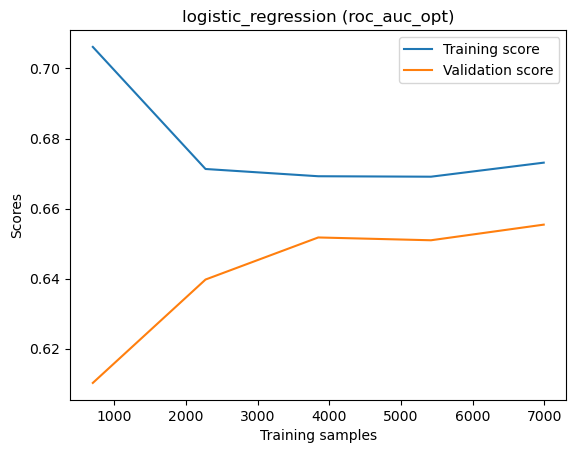

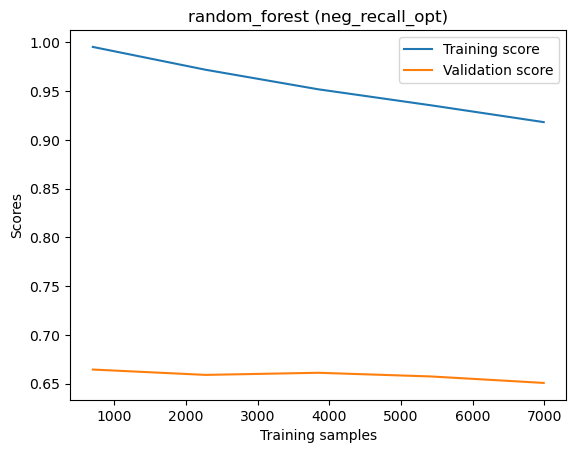

In [26]:
for (key, model) in models_ambulance_r.items():
    if key == 'base_model (log_reg_unweighted)':
        continue
    train_sizes, train_scores, test_scores = learning_curve(model, X_train, y_train, cv=5)
    plt.plot(train_sizes, train_scores.mean(axis=1), label='Training score')
    plt.plot(train_sizes, test_scores.mean(axis=1), label='Validation score')
    plt.legend()
    plt.xlabel('Training samples')
    plt.ylabel('Scores')
    plt.title(key)
    plt.show()

### Final Evaluation

MODEL: logistic_regression (roc_auc_opt)
CONFUSION MATRIX:


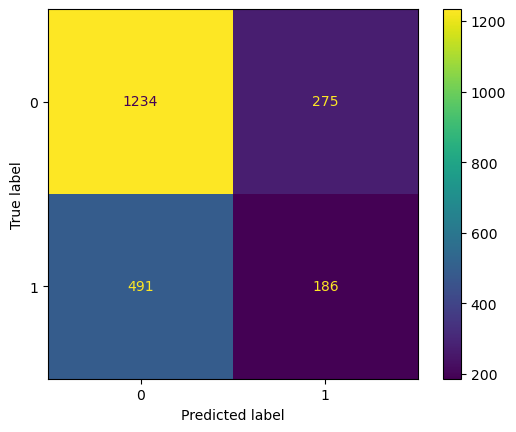

METRICS:
accuracy : 0.6495882891125343
precision (class 0) : 0.7153623188405797
recall (class 0) : 0.8177601060304838
f1-score (class 0) : 0.7631416202844774
roc_auc_score : 0.5462508063387279
-----------------------------------


MODEL: random_forest (neg_recall_opt)
CONFUSION MATRIX:


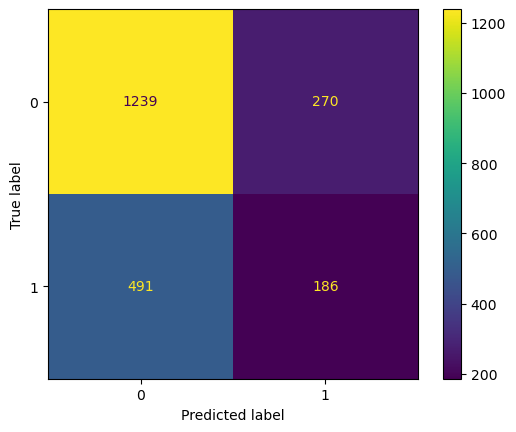

METRICS:
accuracy : 0.651875571820677
precision (class 0) : 0.7161849710982658
recall (class 0) : 0.8210735586481114
f1-score (class 0) : 0.765050941648657
roc_auc_score : 0.5479075326475417
-----------------------------------




In [27]:
X_test = Bike_test[features]
y_test = Bike_test['AmbulanceR']

for (key, model) in models_ambulance_r.items():
    if key == 'base_model (log_reg_unweighted)':
        continue
    # evaluate model
    y_pred = model.predict(X_test)

    print('MODEL:', key)
    print('CONFUSION MATRIX:')
    ConfusionMatrixDisplay.from_predictions(y_test, y_pred)
    plt.show()
    print('METRICS:')
    print('accuracy', ':', (accuracy_score(y_test, y_pred)))
    print('precision (class 0)', ':', (precision_score(y_test, y_pred, pos_label=0)))
    print('recall (class 0)', ':', (recall_score(y_test, y_pred, pos_label=0)))
    print('f1-score (class 0)', ':', (f1_score(y_test, y_pred, pos_label=0)))
    print('roc_auc_score', ':', (roc_auc_score(y_test, y_pred)))
    print('-----------------------------------')
    print('\n')

## Target: Bike Injury (Binary)

### Cross Validation

We'll first test our models using the BikeInjury column as our target. This has the following values:
- 'O: No Injury'
- 'C: Possible Injury'
- 'B: Suspected Minor Injury'
- 'A: Suspected Serious Injury'
- 'K: Killed':

To avoid complicating the model, we'll first test it by converting it into a binary column:
- 'A: Suspected Serious Injury' and 'K: Killed' are classified as 1, i.e. Severy Injury.
- Otherwise, it is classified as 0, i.e. Not Severe Injury.

Notice in the code below, we don't touch the Bike_test.

We only do the cross-validation on the training data set.

#### Set-up

In [28]:
# Start out with our base model
models_bike_injury = {
    'base_model (log_reg_unweighted)': LogisticRegression(penalty=None, max_iter=1000)
}

In [29]:
# Splitting the data into training and test sets, stratifying on Ambulance Response
Bike_train, Bike_test = train_test_split(BikeCrashData.copy(),
                                        shuffle=True, 
                                        test_size=0.2, 
                                        random_state=614,
                                        stratify=BikeCrashData['BikeInjury'])

features = Bike_train.drop(columns=['AmbulanceR','BikeInjury']).columns
X_train = Bike_train[features]
y_train = Bike_train['BikeInjury']


In [30]:
# Create a list of class weights to test out in different models
inj_weights_bike_injury = list(range(8, 12))
inj_weights_bike_injury = [{0: weight, 1: 100 - weight} for weight in inj_weights_bike_injury]

In [32]:
# Using GridSearchCV to find the best hyperparameters for the Logistic Regression model
inj_log_grid_cv = GridSearchCV(LogisticRegressionThreshold(), 
                          param_grid = {'threshold': [threshold / 100 for threshold in list(range(45, 55))],
                                        'penalty': [None],
                                        'max_iter': [1000],
                                        'class_weight': inj_weights_bike_injury}, 
                          scoring = 'recall',
                          cv = skf(n_splits=5))

inj_log_grid_cv.fit(X_train, y_train)

# Add our best estimator to the models to cross-validate
models_bike_injury['logistic_regression (recall_opt)'] = inj_log_grid_cv.best_estimator_

In [33]:
# Using GridSearchCV to find the best hyperparameters for the Random Forest model
inj_for_grid_cv = GridSearchCV(RandomForestClassifierThreshold(), 
                          param_grid = {'threshold': [0.4],
                                        'n_estimators': [250, 500, 1000],
                                        'max_depth': [8, 10, 12],
                                        'class_weight': ['balanced']},
                          scoring = 'recall',
                          cv = skf(n_splits=5))

inj_for_grid_cv.fit(X_train, y_train)

# Add our best estimator to the models to cross-validate
models_bike_injury['random_forest (recall_opt)'] = inj_for_grid_cv.best_estimator_

In [34]:
# Print out models
models_bike_injury

{'base_model (log_reg_unweighted)': LogisticRegression(max_iter=1000, penalty=None),
 'logistic_regression (recall_opt)': LogisticRegressionThreshold(class_weight={0: 8, 1: 92}, max_iter=1000,
                             multi_class='deprecated', penalty=None,
                             threshold=0.45),
 'random_forest (recall_opt)': RandomForestClassifierThreshold(class_weight='balanced', max_depth=8,
                                 n_estimators=250, threshold=0.4)}

#### Results

MODEL: base_model (log_reg_unweighted)
CONFUSION MATRICES:


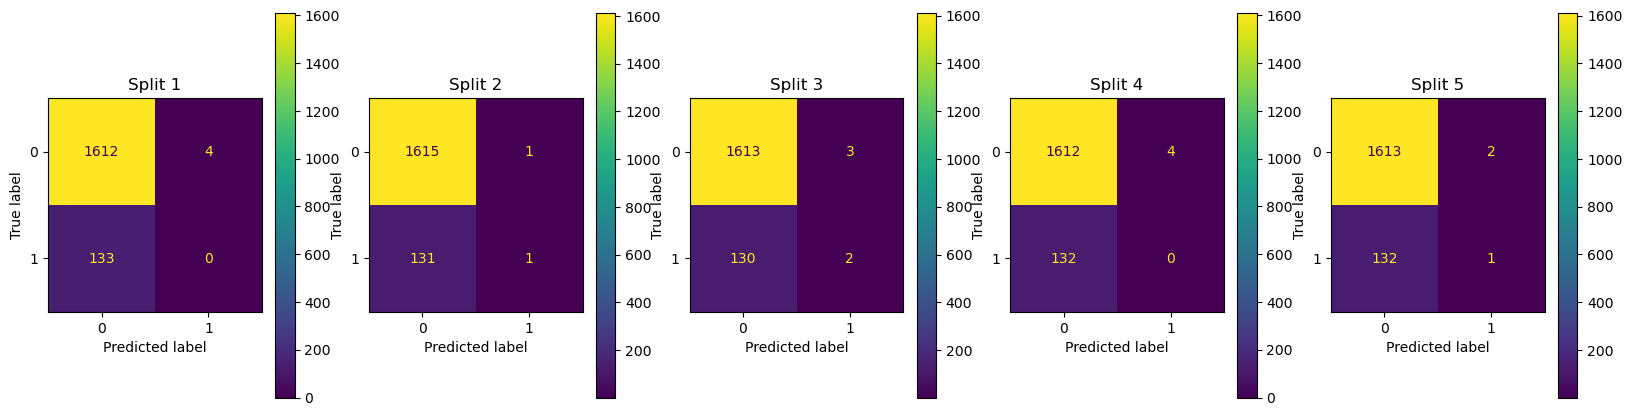

AVERAGE METRICS:
accuracy : 0.9231210904433131
precision (class 1) : 0.24666666666666667
recall (class 1) : 0.006049213943950786
f1-score (class 1) : 0.011765667155848068
roc_auc_score : 0.5021581937052618
-----------------------------------


MODEL: logistic_regression (recall_opt)
CONFUSION MATRICES:


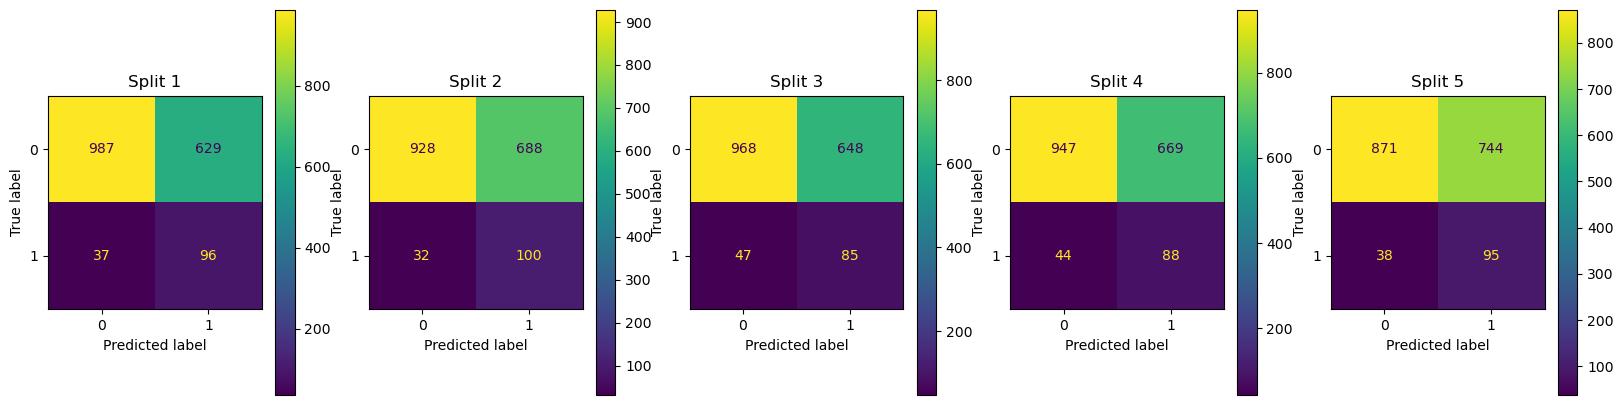

AVERAGE METRICS:
accuracy : 0.5908902504602171
precision (class 1) : 0.12095150634467884
recall (class 1) : 0.7008544087491455
f1-score (class 1) : 0.2062295648307469
roc_auc_score : 0.641364043414514
-----------------------------------


MODEL: random_forest (recall_opt)
CONFUSION MATRICES:


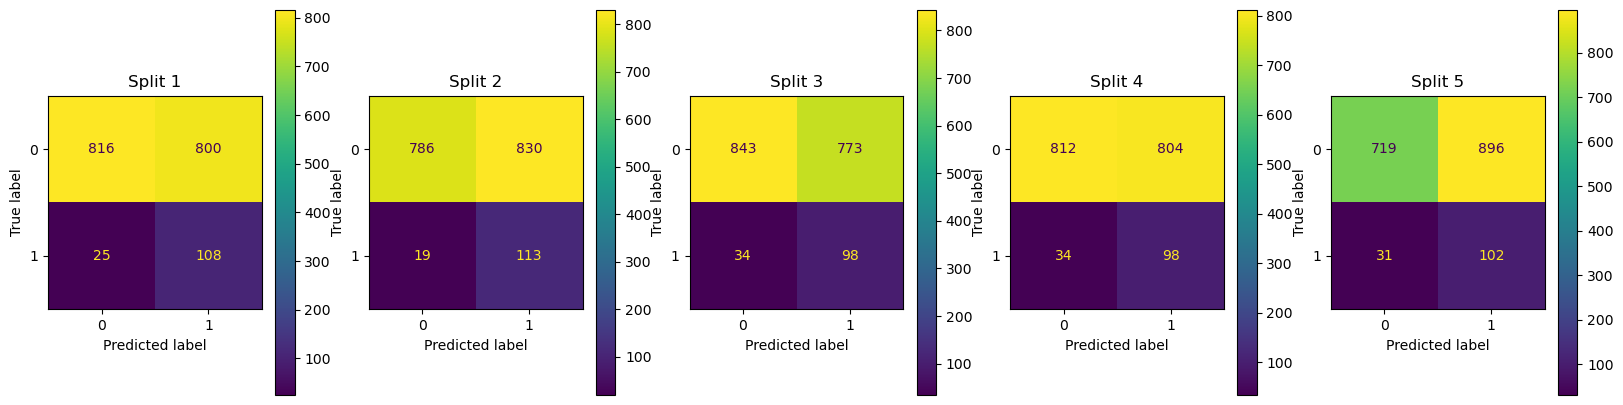

AVERAGE METRICS:
accuracy : 0.514241613056431
precision (class 1) : 0.11242785405288491
recall (class 1) : 0.7839712918660287
f1-score (class 1) : 0.19661311815257934
roc_auc_score : 0.638052799474994
-----------------------------------




In [35]:
for (key, model) in models_bike_injury.items():
    print('MODEL:', key)
    print('CONFUSION MATRICES:')
    metrics = model_metrics(model, X_train, y_train, 5)
    print('AVERAGE METRICS:')
    for (metric, value) in metrics.items():
        print(metric, ':', value)
    print('-----------------------------------')
    print('\n')

#### Check Overfitting

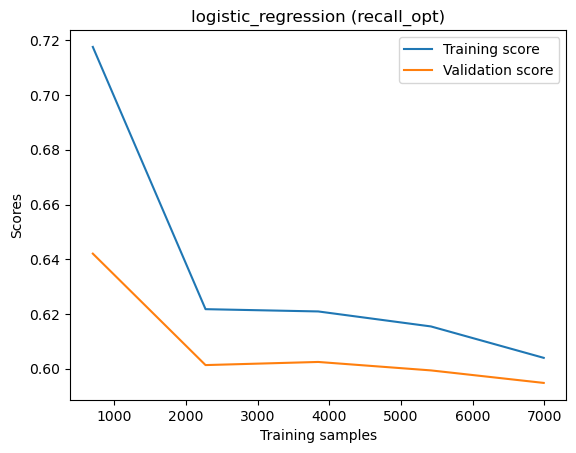

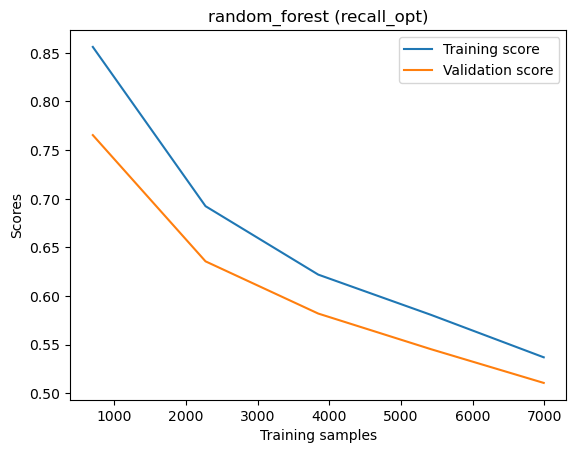

In [36]:
for (key, model) in models_bike_injury.items():
    if key == 'base_model (log_reg_unweighted)':
        continue
    train_sizes, train_scores, test_scores = learning_curve(model, X_train, y_train, cv=5)
    plt.plot(train_sizes, train_scores.mean(axis=1), label='Training score')
    plt.plot(train_sizes, test_scores.mean(axis=1), label='Validation score')
    plt.legend()
    plt.xlabel('Training samples')
    plt.ylabel('Scores')
    plt.title(key)
    plt.show()

### Final Evaluation

MODEL: logistic_regression (recall_opt)
CONFUSION MATRIX:


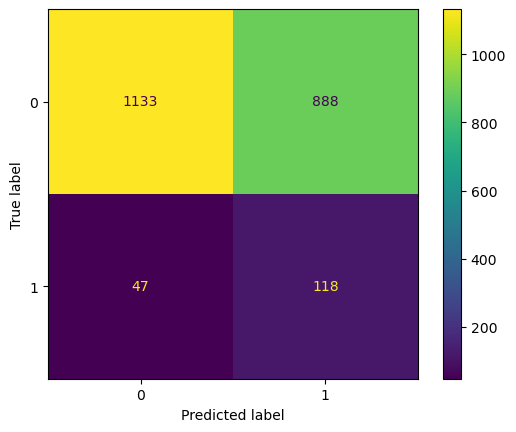

METRICS:
accuracy : 0.5722781335773102
precision (class 1) : 0.1172962226640159
recall (class 1) : 0.7151515151515152
f1-score (class 1) : 0.20153714773697695
roc_auc_score : 0.6378825363981228
-----------------------------------


MODEL: random_forest (recall_opt)
CONFUSION MATRIX:


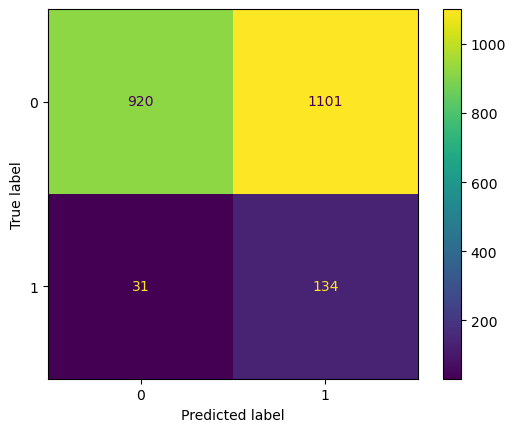

METRICS:
accuracy : 0.48215919487648673
precision (class 1) : 0.10850202429149798
recall (class 1) : 0.8121212121212121
f1-score (class 1) : 0.19142857142857142
roc_auc_score : 0.6336707000734709
-----------------------------------




In [37]:
X_test = Bike_test[features]
y_test = Bike_test['BikeInjury']

for (key, model) in models_bike_injury.items():
    if key == 'base_model (log_reg_unweighted)':
        continue
    # evaluate model
    y_pred = model.predict(X_test)

    print('MODEL:', key)
    print('CONFUSION MATRIX:')
    ConfusionMatrixDisplay.from_predictions(y_test, y_pred)
    plt.show()
    print('METRICS:')
    print('accuracy', ':', (accuracy_score(y_test, y_pred)))
    print('precision (class 1)', ':', (precision_score(y_test, y_pred)))
    print('recall (class 1)', ':', (recall_score(y_test, y_pred)))
    print('f1-score (class 1)', ':', (f1_score(y_test, y_pred)))
    print('roc_auc_score', ':', (roc_auc_score(y_test, y_pred)))
    print('-----------------------------------')
    print('\n')